## Logistic Regression with Tensorflow
This notebook will focus on going through the mechanics of setting up a logistic regression machine learning model with the Tensorflow framework.

In [1]:
# Import necessary packages
import numpy as np
import pandas as pd
import pandas_profiling

import seaborn as sns
sns.set(style='whitegrid')
import matplotlib.pyplot as plt
import sys

import tensorflow as tf

### Read data
In this example we will use the Iris dataset. Using Pandas Profiling we can check the basic characteristics of the dataset.

In [2]:
df = pd.read_csv('../data/Iris.csv')

In [3]:
#pandas_profiling.ProfileReport(df)

In [4]:
# Or the classic way:
print(df.shape)
df.head()

(150, 6)


,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [5]:
# Unique classes in the dataset
list(df.Species.unique())

['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']

In [6]:
%matplotlib inline

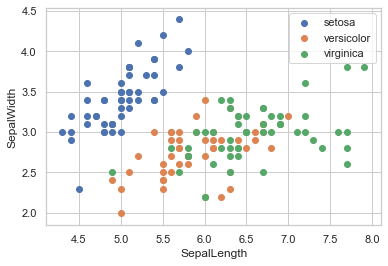

In [7]:
plt.scatter(df[df['Species']=='Iris-setosa'].SepalLengthCm, df[df['Species']=='Iris-setosa'].SepalWidthCm, label='setosa')
plt.scatter(df[df['Species']=='Iris-versicolor'].SepalLengthCm, df[df['Species']=='Iris-versicolor'].SepalWidthCm, label='versicolor')
plt.scatter(df[df['Species']=='Iris-virginica'].SepalLengthCm, df[df['Species']=='Iris-virginica'].SepalWidthCm, label='virginica')
plt.xlabel('SepalLength')
plt.ylabel('SepalWidth')
plt.legend(loc='best')
plt.show();

Let's create a model that can predict if the species is Iris-versicolor if we only look at setosa/versicolor.<br>To do that, we need to filter the dataframe and recode the variable Species.

In [8]:
df = df[(df['Species'] == 'Iris-versicolor') | (df['Species'] == 'Iris-setosa')]

In [9]:
df['Species'] = np.where(df['Species'] == 'Iris-setosa', 1, 0)

In [10]:
print(df.shape)
df.head()

(100, 6)


,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,1
1,2,4.9,3.0,1.4,0.2,1
2,3,4.7,3.2,1.3,0.2,1
3,4,4.6,3.1,1.5,0.2,1
4,5,5.0,3.6,1.4,0.2,1


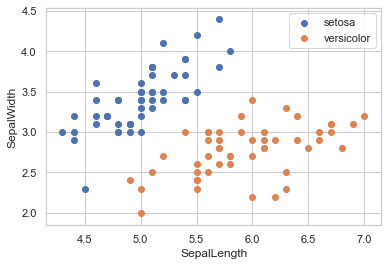

In [11]:
plt.scatter(df[df['Species']==1].SepalLengthCm, df[df['Species']==1].SepalWidthCm, label='setosa')
plt.scatter(df[df['Species']==0].SepalLengthCm, df[df['Species']==0].SepalWidthCm, label='versicolor')
plt.xlabel('SepalLength')
plt.ylabel('SepalWidth')
plt.legend(loc='best')
plt.show();

### Data prep

In [12]:
# Create X and y-variables for prediction
X = df.drop(labels=['Id', 'Species'], axis=1).values
y = df['Species'].values

In [13]:
# Create train and test split (60/40)
# set for reproducible results
seed = 101
np.random.seed(seed)
tf.set_random_seed(seed)

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)

In [15]:
# Define the normalized function
def min_max_normalized(data):
    col_max = np.max(data, axis=0)
    col_min = np.min(data, axis=0)
    return np.divide(data - col_min, col_max - col_min)

In [16]:
# Normalize dataset
X_train = min_max_normalized(X_train)
X_test = min_max_normalized(X_test)

### Define the model

In [17]:
# Begin building the model framework
# Declare the variables that need to be learned and initialization
# There are 4 features here, A's dimension is (4, 1)
A = tf.Variable(tf.random_normal(shape=[4, 1]))
b = tf.Variable(tf.random_normal(shape=[1, 1]))

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

Instructions for updating:
Colocations handled automatically by placer.


In [18]:
# Define placeholders
data = tf.placeholder(dtype=tf.float32, shape=[None, 4])
target = tf.placeholder(dtype=tf.float32, shape=[None, 1])

In [19]:
# Declare the model you need to learn
mod = tf.matmul(data, A) + b

In [20]:
# Declare loss function
# Use the sigmoid cross-entropy loss function,
# first doing a sigmoid on the model result and then using the cross-entropy loss function
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=mod, labels=target))

In [21]:
# Define the learning rate， batch_size etc.
learning_rate = 0.003
batch_size = 30
iter_num = 1500

In [22]:
# Define the optimizer
opt = tf.train.GradientDescentOptimizer(learning_rate)

In [23]:
# Define the goal
goal = opt.minimize(loss)

In [24]:
# Define the accuracy
# The default threshold is 0.5, rounded off directly
prediction = tf.round(tf.sigmoid(mod))

# Bool into float32 type
correct = tf.cast(tf.equal(prediction, target), dtype=tf.float32)

# Average
accuracy = tf.reduce_mean(correct)

### Train the model

In [25]:
# Start training model
# Define the variable that stores the result
loss_trace = []
train_acc = []
test_acc = []

In [26]:
# training model
for epoch in range(iter_num):
    # Generate random batch index
    batch_index = np.random.choice(len(X_train), size=batch_size)
    batch_X_train = X_train[batch_index]
    batch_y_train = np.matrix(y_train[batch_index]).T
    sess.run(goal, feed_dict={data: batch_X_train, target: batch_y_train})
    temp_loss = sess.run(loss, feed_dict={data: batch_X_train, target: batch_y_train})
    
    # convert into a matrix, and the shape of the placeholder to correspond
    temp_train_acc = sess.run(accuracy, feed_dict={data: X_train, target: np.matrix(y_train).T})
    temp_test_acc = sess.run(accuracy, feed_dict={data: X_test, target: np.matrix(y_test).T})
    
    # recode the result
    loss_trace.append(temp_loss)
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    
    # output
    if (epoch + 1) % 300 == 0:
        print('epoch: {:4d} loss: {:5f} train_acc: {:5f} test_acc: {:5f}'.format(epoch + 1, temp_loss,
                                                                          temp_train_acc, temp_test_acc))

epoch:  300 loss: 1.553665 train_acc: 0.450000 test_acc: 0.575000
epoch:  600 loss: 1.116872 train_acc: 0.450000 test_acc: 0.550000
epoch:  900 loss: 0.727525 train_acc: 0.483333 test_acc: 0.575000
epoch: 1200 loss: 0.643767 train_acc: 0.683333 test_acc: 0.675000
epoch: 1500 loss: 0.541083 train_acc: 0.883333 test_acc: 0.850000


### Visualize the model


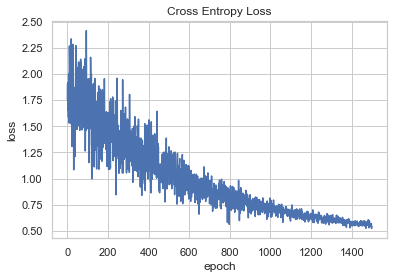

In [27]:
# Visualization of the results
# loss function
plt.plot(loss_trace)
plt.title('Cross Entropy Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

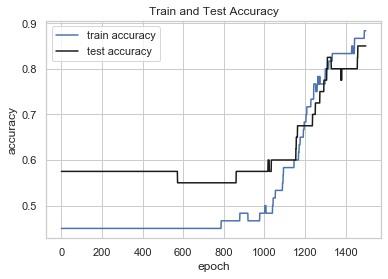

In [28]:
# accuracy
plt.plot(train_acc, 'b-', label='train accuracy')
plt.plot(test_acc, 'k-', label='test accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Train and Test Accuracy')
plt.legend(loc='best')
plt.show()

As you can see we got some decent results with an initial model, the minimum accuracy landed at 0.85 for the test set which is pretty decent. But the main goal was to see if we could design a logistic regression model using Tensorflow instead of scikit-learn which we did.

